# Final notebook for Millestone 3

For this last version, we kept our first analysis, and we tried to dig deeper in the texual content (reviews and their summaries) and we tried to work on categories of products separately, since we thought that every reviews in the same category can have so much in common, and if we worked on the whole categories in common we might've lost some important insights. We kept the same notebook, we just changed a little bit the order. But we mentionned when we filled the empty cells from Millestone2.

In [58]:
data_path = 'data/full/'

# Replace by the file of the category you wish to work with
dataset_path = data_path + 'amazon_reviews_us_Video_Games_v1_00.tsv.gz'


### imports

In [2]:
%load_ext autoreload
%autoreload 2

import gensim
import time
import json
import gzip
import re
import itertools
import regex
import pandas as pd
import gzip
import datetime
import scipy.stats as stats
import math
import seaborn as sns
import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle

seed = 42
random.seed(seed)
np.random.seed(seed)

# Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline  

# NLP libraries
import spacy, nltk, sklearn
import pyLDAvis.gensim
from nltk.corpus import stopwords
from typing import Optional
pd.options.mode.chained_assignment = None 

# Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [4]:
# Plot settings
plt.rcParams['figure.dpi'] = 100
sns.set()  # Use default seaborn styling for all plots
sns.set_context('notebook')

# Preproccesing:

As we have a very large dataset containing reviews of all amazon's products in  differents subsets by type:

* Books	
* Electronics	
* Movies and TV	
* CDs and Vinyl	
* Clothing, Shoes and Jewelry	
* Home and Kitchen	
* Kindle Store	
* Sports and Outdoors	
* Cell Phones and Accessories	
* Health and Personal Care	
* Toys and Games	
* Video Games	
* Tools and Home Improvement		
* Beauty	
* Apps for Android	
* Office Products	
* Pet Supplies	
* Automotive	5-core 
* Grocery and Gourmet Food	
* Patio, Lawn and Garden	
* Baby	5-core 
* Digital Music	
* Musical Instruments	
* Amazon Instant Video

For this step, we chose to work with a small subsets to perform our preprocessing, and to have a first idea how efficient it was since we don't handle textual data. We will start by exploring the data, products reviewed and ratings, and try to extract meaningful information, and then we will handle the textual reviews, clean it as much as possible.



* Useful functions for reading data, provided by Amazon.

In [5]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)


def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

### Step 1 : Loading the dataset
* Reading the dataset and displaying some important figures.

In [6]:
df = pd.read_csv(
    dataset_path,
    error_bad_lines=False,
    sep='\t',
    header=0
)


df.head(4)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31


In [7]:
df = df[['customer_id', 'product_id', 'helpful_votes', 'total_votes', 'review_headline', 'star_rating', 'review_body', 'review_date']]

df = df.rename(columns={
    'customer_id': 'reviewerID',
    'product_id': 'asin',
    'review_headline': 'summary',
    'review_body': 'reviewText',
    'star_rating': 'overall',
    'review_date': 'reviewTime'
}).dropna()

df['unixReviewTime'] = df.reviewTime.map(lambda s: int(time.mktime(datetime.datetime.strptime(s, '%Y-%m-%d').timetuple())))

In [8]:
df.head(4)

,reviewerID,asin,helpful_votes,total_votes,summary,overall,reviewText,reviewTime,unixReviewTime
0,12039526,B001CXYMFS,0,0,an amazing joystick. I especially love that yo...,5,"Used this for Elite Dangerous on my mac, an am...",2015-08-31,1440972000
1,9636577,B00M920ND6,0,0,Definitely a silent mouse... Not a single clic...,5,"Loved it, I didn't even realise it was a gami...",2015-08-31,1440972000
2,2331478,B0029CSOD2,0,1,One Star,1,poor quality work and not as it is advertised.,2015-08-31,1440972000
3,52495923,B00GOOSV98,0,0,"good, but could be bettee",3,"nice, but tend to slip away from stick in inte...",2015-08-31,1440972000


In [9]:
df.dtypes

reviewerID         int64
asin              object
helpful_votes      int64
total_votes        int64
summary           object
overall            int64
reviewText        object
reviewTime        object
unixReviewTime     int64
dtype: object


In [11]:
df.describe()

,reviewerID,helpful_votes,total_votes,overall,unixReviewTime
count,1.780154e+06,1.780154e+06,1.780154e+06,1.780154e+06,1.780154e+06
mean,2.803067e+07,2.264000e+00,3.764151e+00,4.059384e+00,1.321901e+09
std,1.562836e+07,1.919271e+01,2.247246e+01,1.355952e+00,1.239756e+08
min,1.001800e+04,0.000000e+00,0.000000e+00,1.000000e+00,8.787708e+08
25%,1.429749e+07,0.000000e+00,0.000000e+00,4.000000e+00,1.274479e+09
50%,2.732258e+07,0.000000e+00,1.000000e+00,5.000000e+00,1.368137e+09
75%,4.274848e+07,1.000000e+00,3.000000e+00,5.000000e+00,1.412892e+09
max,5.309656e+07,1.049800e+04,1.078000e+04,5.000000e+00,1.440972e+09


In [12]:
# Basic figures for this sample.
nb_articles = df['asin'].unique().shape[0]
nb_reviewers = df['reviewerID'].unique().shape[0]
nb_reviews = df.shape[0]

print("Number of reviews : %d " % nb_reviews)
print("Number of articles reviewed : %d " % nb_articles)
print("Number of  reviewers  : %d " % nb_reviewers)

Number of reviews : 1780154 
Number of articles reviewed : 65685 
Number of  reviewers  : 1043049 


### Step 2 : Textual description preprocessing

1.  We try to create a dictionnary of text normalization, wchich can be helpful to substitute incorrect words with correct one. We have two references : 


 * link1( http://www.hlt.utdallas.edu/~yangl/data/Text_Norm_Data_Release_Fei_Liu/)
 * link2( http://luululu.com/tweet/typo-corpus-r1.txt)


In [13]:
def load_lexical_normalization():
    """
    Function to load lexical normalization dictionaries found online: 
        http://www.hlt.utdallas.edu/~yangl/data/Text_Norm_Data_Release_Fei_Liu/
        http://luululu.com/tweet/typo-corpus-r1.txt
    These dictionaries help perform a spell check on reviews and convert their 
    words to normal english words
    Result: lex_orm : a dictionary, the keys are incorrect words and the values are correct words
    """
    lex_norm = {}
    
    dictionary1 = open('helpers/TextNormalization.txt', 'rb')
    for word in dictionary1:
        word = word.decode('utf8')
        word = word.split()
        lex_norm[word[1]] = word[3]
    dictionary1.close()
    dictionary2 = open('helpers/TypoCorpus.txt', 'rb')
    for word in dictionary2:
        word = word.decode('utf8')
        word = word.split()
        lex_norm[word[0]] = word[1]
    dictionary2.close()
    return lex_norm
lex_norm = load_lexical_normalization()


def spell_check(review):
    """
    Function that corrects words using the corpus loaded with load_lexical_normalization()
    Arguments: 
        review: a string that represents the raw review
        lexNorm: a dictionary
    Result: a string that represents the corrected review
    """
    review = review.split()
    for i in range(len(review)):
        if review[i] in lex_norm.keys():
            review[i] = lex_norm[review[i]]
    review = ' '.join(review)
    return review


def clean_char_repetitions(review):
    """
    Function that removes repeated letters in words
    """
    
    review=review.split()
    for i in range(len(review)):
        review[i]=''.join(''.join(s)[:2] for _, s in itertools.groupby(review[i])).replace('#', '')

    review=' '.join(review)
    return review


def spell_preprocessing(review):
    ''' 
    Apply the two previous functions
    '''
    review = spell_check(review)
    return clean_char_repetitions(review)


# Add word  adn char count
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['reviewText'].str.len() 

df.head()

,reviewerID,asin,helpful_votes,total_votes,summary,overall,reviewText,reviewTime,unixReviewTime,word_count,char_count
0,12039526,B001CXYMFS,0,0,an amazing joystick. I especially love that yo...,5,"Used this for Elite Dangerous on my mac, an am...",2015-08-31,1440972000,33,178
1,9636577,B00M920ND6,0,0,Definitely a silent mouse... Not a single clic...,5,"Loved it, I didn't even realise it was a gami...",2015-08-31,1440972000,49,262
2,2331478,B0029CSOD2,0,1,One Star,1,poor quality work and not as it is advertised.,2015-08-31,1440972000,9,46
3,52495923,B00GOOSV98,0,0,"good, but could be bettee",3,"nice, but tend to slip away from stick in inte...",2015-08-31,1440972000,14,81
4,14533949,B00Y074JOM,0,0,Great but flawed.,4,"Great amiibo, great for collecting. Quality ma...",2015-08-31,1440972000,14,90


### Applying textual preprocessing


In [14]:
# apply spell preprocessing to the review body
df['reviewText'] = df['reviewText'].map(spell_preprocessing)

#Transform reviews to lower case to avoid repetitions of the words.
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removing ponctuation
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]','')

<input>:8: DeprecationWarning: invalid escape sequence \w
<input>:8: DeprecationWarning: invalid escape sequence \w
<input>:8: DeprecationWarning: invalid escape sequence \w
<ipython-input-14-6d3d340f83c8>:8: DeprecationWarning: invalid escape sequence \w
  df['reviewText'] = df['reviewText'].str.replace('[^\w\s]','')


In [15]:
# Remove stopwords: that, is, are ..
nltk.download('stopwords')
stop = stopwords.words('english')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/braymond/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
print("List of stopwords filtred: \n")

stop

List of stopwords filtred: 
 
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 

In [17]:
# redo the word count 
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['reviewText'].str.len() 

df.head()

,reviewerID,asin,helpful_votes,total_votes,summary,overall,reviewText,reviewTime,unixReviewTime,word_count,char_count
0,12039526,B001CXYMFS,0,0,an amazing joystick. I especially love that yo...,5,used elite dangerous mac amazing joystick espe...,2015-08-31,1440972000,17,118
1,9636577,B00M920ND6,0,0,Definitely a silent mouse... Not a single clic...,5,loved didnt even realise gaming mouse typed 34...,2015-08-31,1440972000,25,173
2,2331478,B0029CSOD2,0,1,One Star,1,poor quality work advertised,2015-08-31,1440972000,4,28
3,52495923,B00GOOSV98,0,0,"good, but could be bettee",3,nice tend slip away stick intense hard pressed...,2015-08-31,1440972000,10,62
4,14533949,B00Y074JOM,0,0,Great but flawed.,4,great amiibo great collecting quality material...,2015-08-31,1440972000,9,68


* We can see that we let go of many unuseful words, and with the remaining one we will try to conduct the final analysis

### End of Preprocessing



# Next step of textual analysis ( See below 2/F)

* For the next milestone, we are going to go deeper into natural language processing, and try to extract information from the text review or the summary (or both) and identify if there is a causality between high helpfulness and a good comment (review)

# Analysis Step : 
###  A/ Visualisation of data

Let's try and visualize distribution of ratings, We will handle:
1. Global ratings 
2. Mean rating per item
3. Mean rating per reviewer

##############################

1. Global ratings 


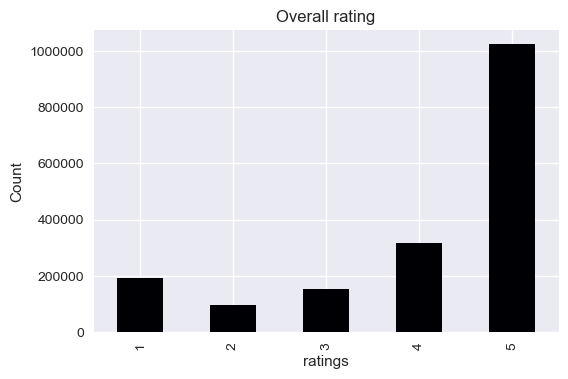

In [18]:
# Plot bins of ratings
summary = df.groupby('overall')['summary'].agg("count")
summary.plot(kind='bar', colormap='inferno')
plt.title('Overall rating')
plt.xlabel('ratings')
plt.ylabel('Count')
plt.rcParams["figure.figsize"] = [13,6]

In [19]:
summary

overall
1     191614
2      94552
3     153443
4     317443
5    1023102
Name: summary, dtype: int64

We can see that a majority of rating scores are 5. 

In [20]:
df_tmp = df
df_tmp['first_rating'] = df_tmp['overall']

gby_product = df_tmp.groupby('asin', as_index=False)[['overall', 'first_rating']].agg({
    'overall': 'mean',
    'first_rating': lambda x: x.iloc[-1]
})


def get_mean_rating(asin):
    return gby_product[asin]


gby_product.head(3)

,asin,overall,first_rating
0,0000118532,3.333333,3
1,006056038X,1.000000,1
2,006073132X,4.000000,4


* Visualize reviewers' behavior towards the items

In [22]:
gby_reviewers = df.groupby('reviewerID',as_index=False)['overall'].mean()
gby_reviewers = pd.DataFrame(gby_reviewers)

gby_reviewers.head(5)

,reviewerID,overall
0,10018,4.25
1,10114,5.00
2,10146,5.00
3,10164,5.00
4,10192,5.00


Text(0,0.5,'Count')

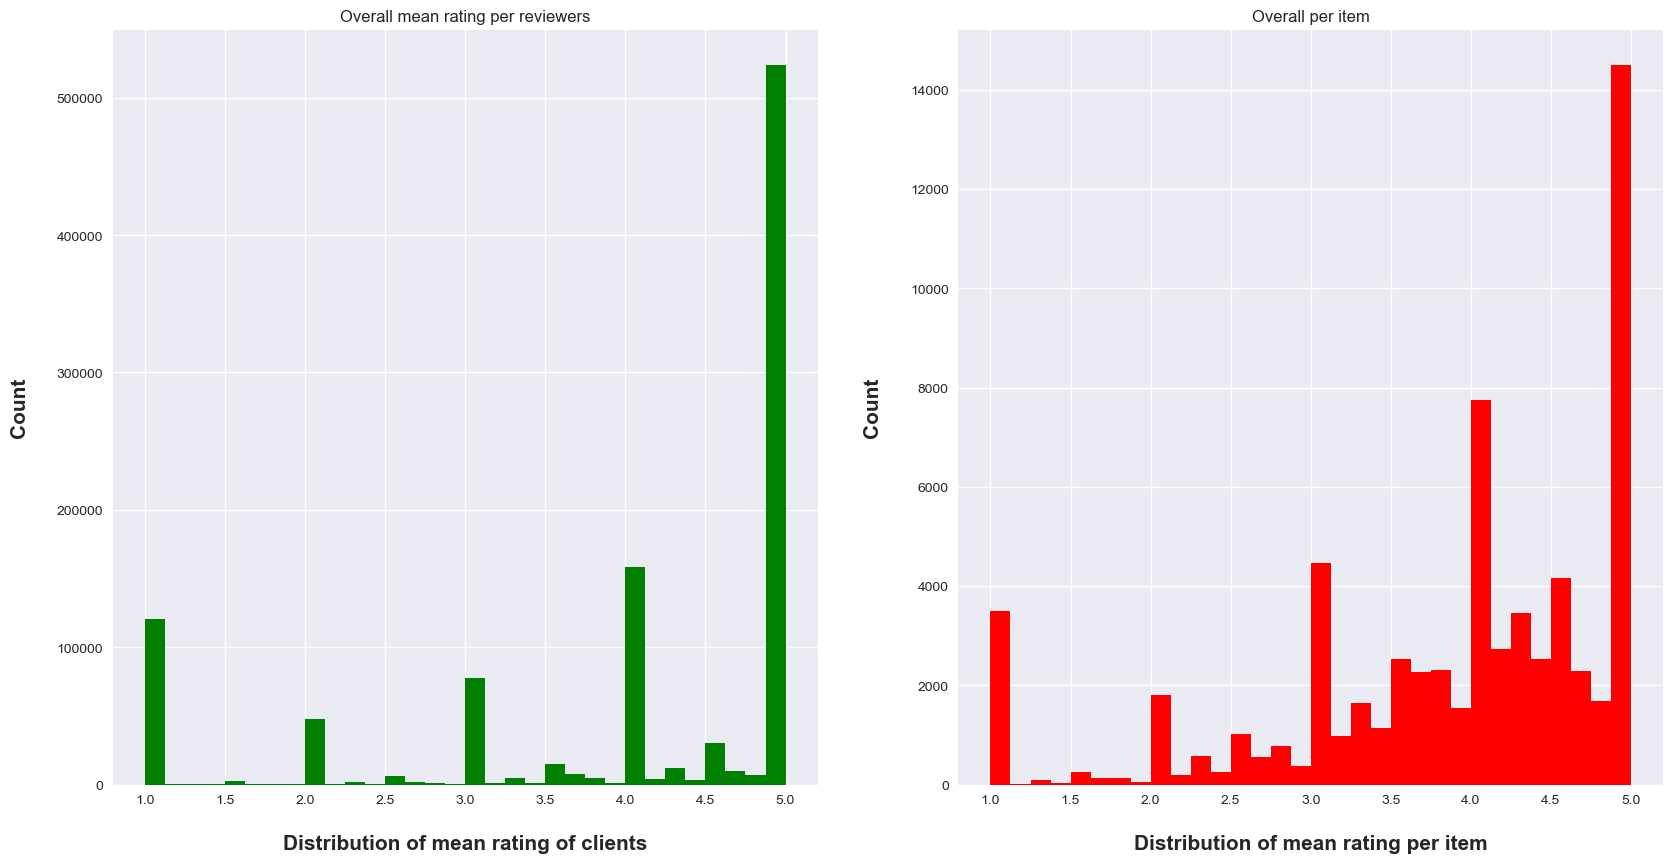

In [23]:
fig, axes = plt.subplots(1, 2,figsize=(20,10))

axes[0].hist(gby_reviewers['overall'], bins=32, facecolor='g')
axes[0].set_title('Overall mean rating per reviewers')
axes[0].set_xlabel('Distribution of mean rating of clients',labelpad=20, weight='bold', size=15)
axes[0].set_ylabel('Count',labelpad=20, weight='bold', size=15)

axes[1].hist(gby_product['overall'], bins=32, facecolor='r')
axes[1].set_title('Overall per item')
axes[1].set_xlabel('Distribution of mean rating per item',labelpad=20, weight='bold', size=15)
axes[1].set_ylabel('Count',labelpad=20, weight='bold', size=15)

In [24]:
mean_rating_items = gby_product['overall'].mean()
mean_rating_reviewers = gby_reviewers['overall'].mean()
mean_rating = df['overall'].mean()

print("Mean rating : %s " % mean_rating)
print("Mean rating per item : %s " % mean_rating_items)
print("Mean rating per reviewer : %s " % mean_rating_reviewers)

Mean rating : 4.0593841881095685 
Mean rating per item : 3.8739509578777414 
Mean rating per reviewer : 3.980509492869059 


### B/  try to analyze reviewers behavior

We're going to look into the number of reviews given for reviewers and see if there's any relationship between how often they give reviews and the rating they give.

In [25]:
def get_nb_reviews(reviewerID):
    return df[df.reviewerID == reviewerID].shape[0]


df['count'] = 1

gby_reviewers['count'] = df \
    .groupby('reviewerID', as_index=False) \
    .agg({'count': sum})['count']

gby_reviewers = gby_reviewers.sort_values(by=['overall'],ascending = False)

Text(0.5,1,'Mean ratings vs number of reviews (per person)')

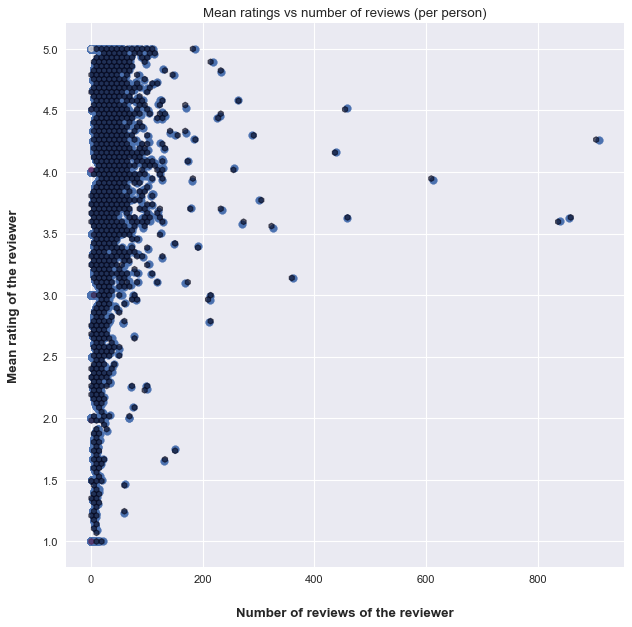

In [26]:
plt.figure(figsize=(9,9), dpi=80)
plt.scatter(gby_reviewers['count'], gby_reviewers.overall)
plt.hexbin(gby_reviewers['count'], gby_reviewers.overall, alpha=.6, mincnt=1)
plt.xlabel('Number of reviews of the reviewer',labelpad=20, weight='bold', size=12)
plt.ylabel('Mean rating of the reviewer',labelpad=20, weight='bold', size=12)
plt.title('Mean ratings vs number of reviews (per person)')

We notice that there is no clear relationship between number of reviews given and the average rating, and yet, we can still see that people who give a lot of reviews tend to give different ratings (not always the same), meanwhile people who doesn't often review items (less than 100 reviews) are the majority and hence, they are the decisive part.

### C/  Analysis of helpfulness of reviews


In [27]:
df['helpful_ratio'] = df['helpful_votes'] / df['total_votes']
df_help = df[['helpful_ratio']].dropna()

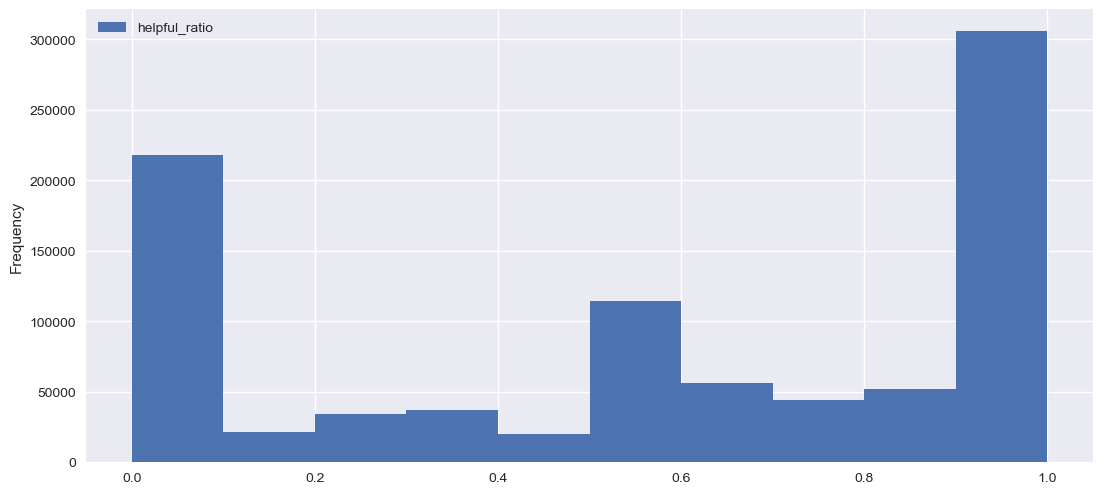

In [28]:
df_help.head()

# Plot distributions of helpfulness
df_help.plot.hist(bins=10)

Helpfulness can be a useful metric for further analysis in the next step, since a majority of reviews can be considered as helpful. We can also extend the analysis to relationship between helpfulness of the review and the textual comment.

### D/ Effect of first reviews on other reviews. (update for Millestone 3)

* We work again with groupedbyItems
* We're going to collect the rating of the first reviews and compare it to the average rating of the item.

### This is one of the main questions we tried to answer, and we will continue to do so when we use the whole dataset, or at least try to find the category of items where this can be considered true.

In [29]:
gby_product.head(10)

,asin,overall,first_rating
0,0000118532,3.333333,3
1,006056038X,1.000000,1
2,006073132X,4.000000,4
3,007876355X,5.000000,5
4,0078764343,4.750000,4
5,0133617300,5.000000,5
6,0182116247,1.000000,1
7,0182116255,5.000000,5
8,0182116263,2.400000,1
9,0226739368,5.000000,5


Text(0,0.5,'Mean overall per item')

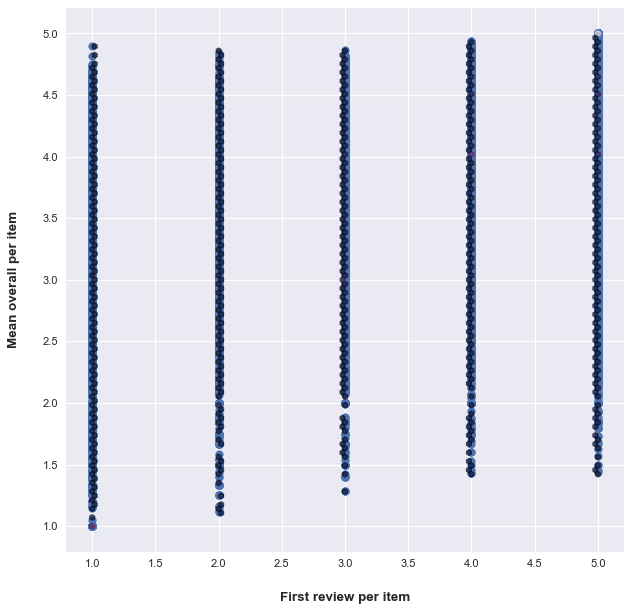

In [30]:
plt.figure(figsize=(9,9), dpi=80)
plt.scatter(gby_product['first_rating'], gby_product.overall)
plt.hexbin(gby_product['first_rating'], gby_product.overall, alpha=.6, mincnt=1)
plt.xlabel('First review per item',labelpad=20, weight='bold', size=12)
plt.ylabel('Mean overall per item',labelpad=20, weight='bold', size=12)

The first reviews doesn't affect the other ratings after all, since mostly we have all occurences of mean ratings after any first ratings. It is due to the fact that Amazon doesn't show reviews in a particular chronological order!

### E/ Applying sentiment analysis of reviews (update millestone 3)



In [31]:
analyzer = SentimentIntensityAnalyzer()

def extract_sentiment(review):
    vs = analyzer.polarity_scores(review)
    if vs['compound'] >= 0.05:
        sentiment = 'positive'
    elif vs['compound'] <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    return sentiment

In [32]:
df['sentiment_review'] = df['reviewText'].map(extract_sentiment)
df['sentiment_summary'] = df['summary'].map(extract_sentiment)

In [33]:
# Save data on disk for later re-analysis
df.to_pickle("./final_df.pkl")
gby_product.to_pickle("./gby_product.pkl")
gby_reviewers.to_pickle("./gby_reviewers.pkl")

In [34]:
# Reload data
df = pd.read_pickle("./petsupplies/final_df.pkl")
gby_product = pd.read_pickle("./petsupplies/gby_product.pkl")
gby_reviewers = pd.read_pickle("./petsupplies/gby_reviewers.pkl")

In [35]:
analyzer = SentimentIntensityAnalyzer()
vs = analyzer.polarity_scores("hate")

vs

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5719}

In [36]:
df.head()

,reviewerID,asin,helpful_votes,total_votes,summary,overall,reviewText,reviewTime,unixReviewTime,word_count,char_count,first_rating,count,helpful_ratio,sentiment_review,sentiment_summary
0,12039526,B001CXYMFS,0,0,an amazing joystick. I especially love that yo...,5,used elite dangerous mac amazing joystick espe...,2015-08-31,1440972000,17,118,5,1,NaN,positive,positive
1,9636577,B00M920ND6,0,0,Definitely a silent mouse... Not a single clic...,5,loved didnt even realise gaming mouse typed 34...,2015-08-31,1440972000,25,173,5,1,NaN,positive,positive
2,2331478,B0029CSOD2,0,1,One Star,1,poor quality work advertised,2015-08-31,1440972000,4,28,1,1,0.0,negative,neutral
3,52495923,B00GOOSV98,0,0,"good, but could be bettee",3,nice tend slip away stick intense hard pressed...,2015-08-31,1440972000,10,62,3,1,NaN,positive,positive
4,14533949,B00Y074JOM,0,0,Great but flawed.,4,great amiibo great collecting quality material...,2015-08-31,1440972000,9,68,4,1,NaN,positive,positive


In [37]:
sent_review = df[['overall', 'sentiment_review']]
sent_summary = df[['overall', 'sentiment_summary']]

### Analysis of reviews's sentiment

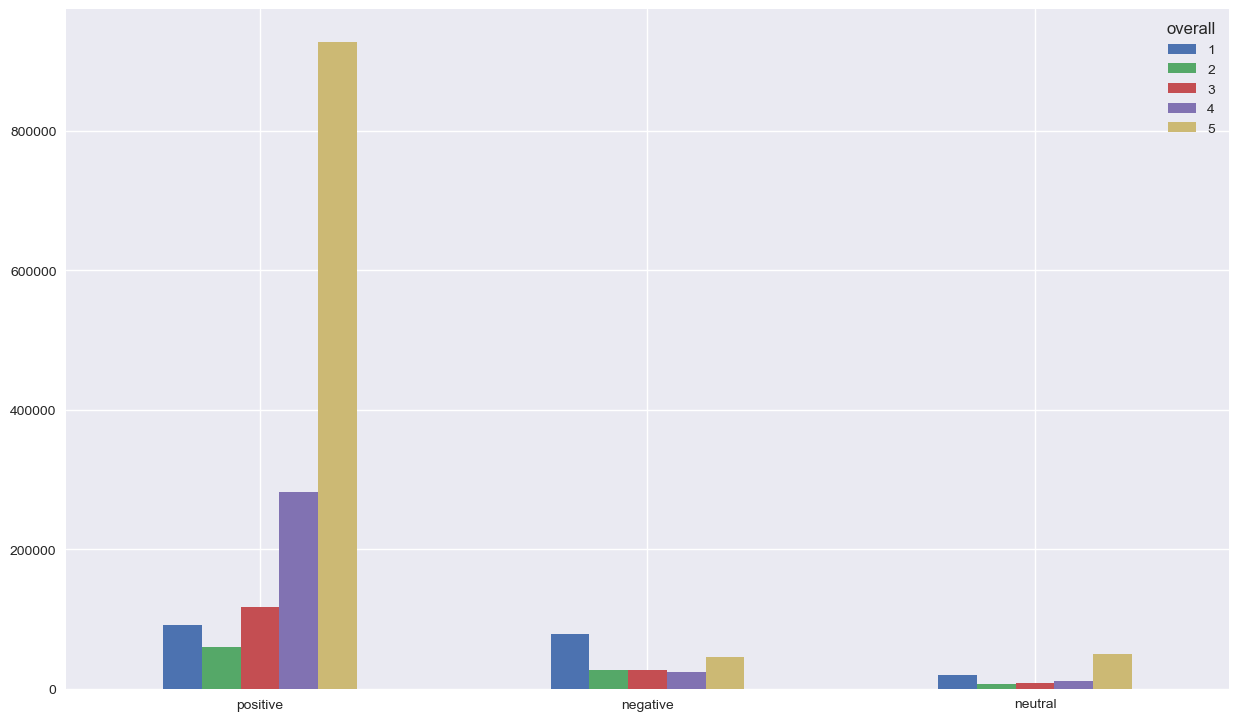

In [38]:
sent_review['count'] = 1
pos = sent_review[sent_review.sentiment_review == 'positive']
neg = sent_review[sent_review.sentiment_review == 'negative']
neut = sent_review[sent_review.sentiment_review == 'neutral']

grouped = pos.groupby('overall').agg({'count': sum})
grouped_neg = neg.groupby('overall').agg({'count': sum})
grouped_neut = neut.groupby('overall').agg({'count': sum})
grouped['negative'] = grouped_neg['count']
grouped['neutral'] = grouped_neut['count']
grouped = grouped.rename(index=str, columns={"count": "positive"})
grouped.T.plot(kind='bar', rot=0, figsize=(15,9))

### Analysis of sumamry's sentiment

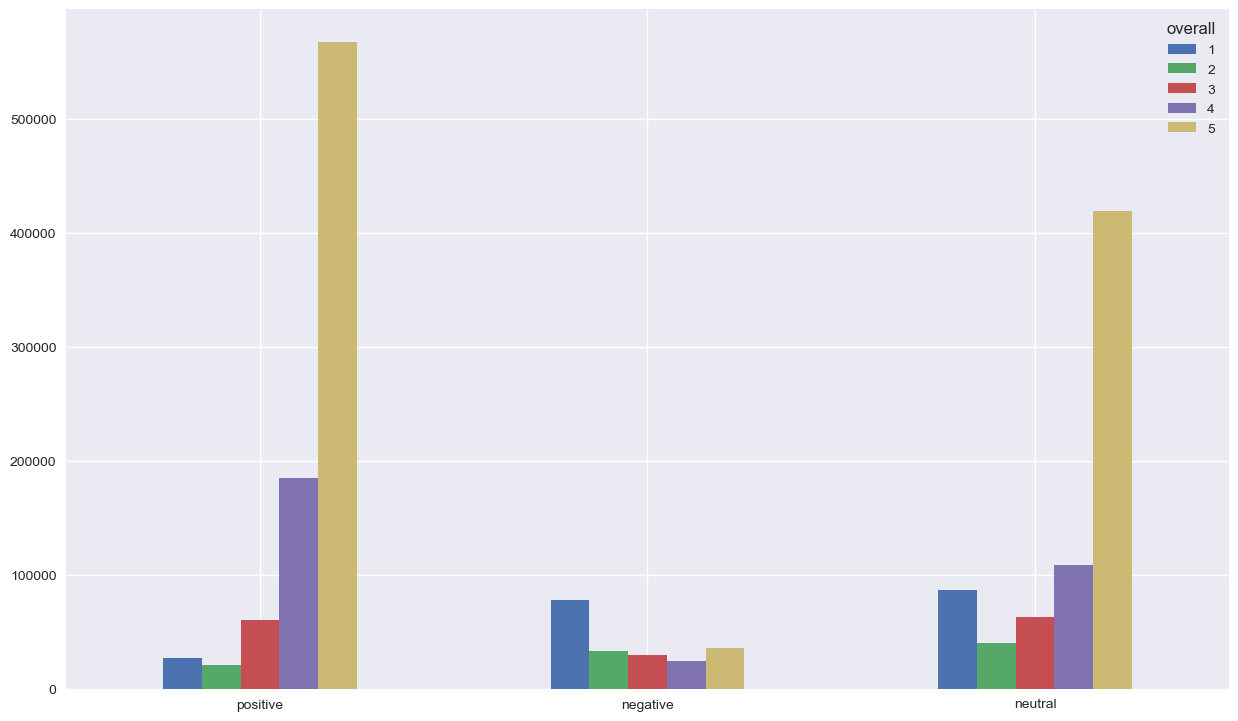

In [39]:
sent_summary['count'] = 1
pos = sent_summary[sent_summary.sentiment_summary =='positive']
neg = sent_summary[sent_summary.sentiment_summary =='negative']
neut = sent_summary[sent_summary.sentiment_summary =='neutral']

grouped = pos.groupby('overall').agg({'count': sum})
grouped_neg = neg.groupby('overall').agg({'count': sum})
grouped_neut = neut.groupby('overall').agg({'count': sum})
grouped['negative'] = grouped_neg['count']
grouped['neutral'] = grouped_neut['count']
grouped = grouped.rename(index=str, columns={"count": "positive"})
grouped.T.plot(kind='bar', rot=0, figsize=(15,9))

### let's find out how many of reviews' sentiment prediction match summaries' sentiment prediction, and explore the misleaging cases

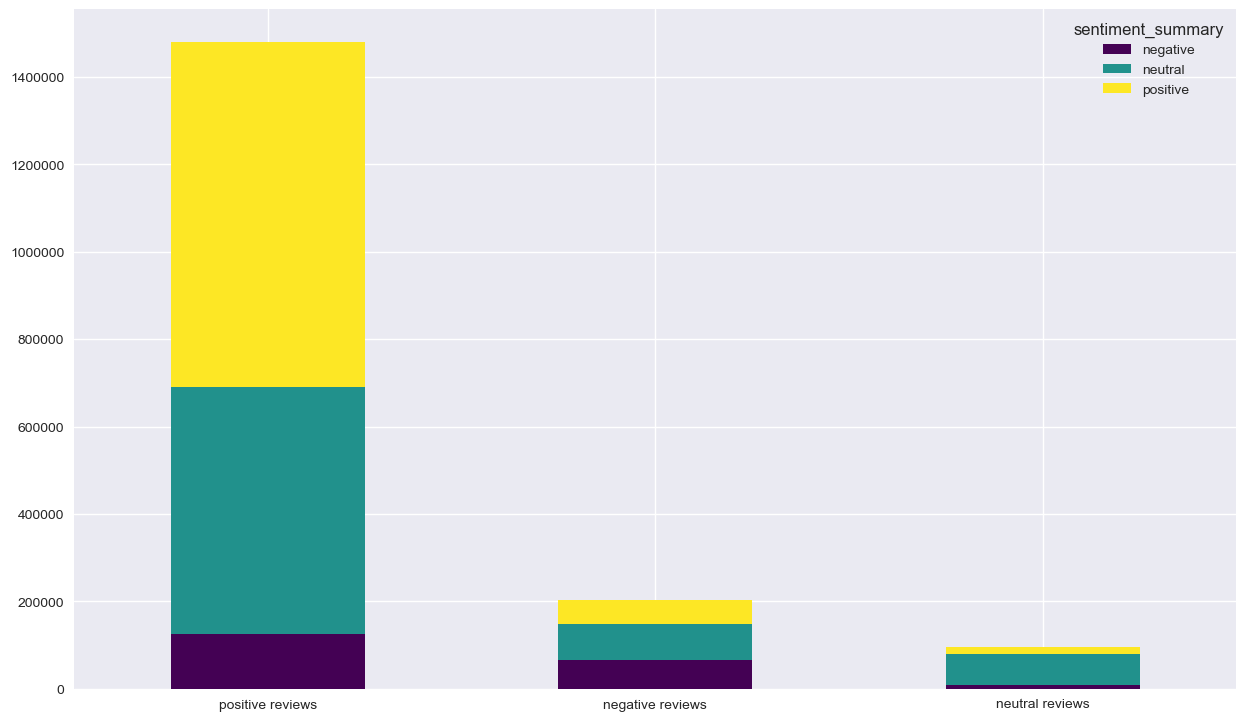

In [40]:
grouped = df[df.sentiment_review == 'positive']
grouped = grouped.groupby('sentiment_summary')['count'].agg({'count': sum})
final = grouped.copy()

final = final.rename(index=str, columns={"count": "positive reviews"})
grouped = df[df.sentiment_review == 'negative']
grouped = grouped.groupby('sentiment_summary')['count'].agg({'count': sum})
final['negative reviews'] = grouped['count']
grouped = df[df.sentiment_review == 'neutral']
grouped = grouped.groupby('sentiment_summary')['count'].agg({'count': sum})
final['neutral reviews'] = grouped['count']
final.T.plot(kind='bar', stacked=True, rot=0, figsize=(15,9), colormap = 'viridis')

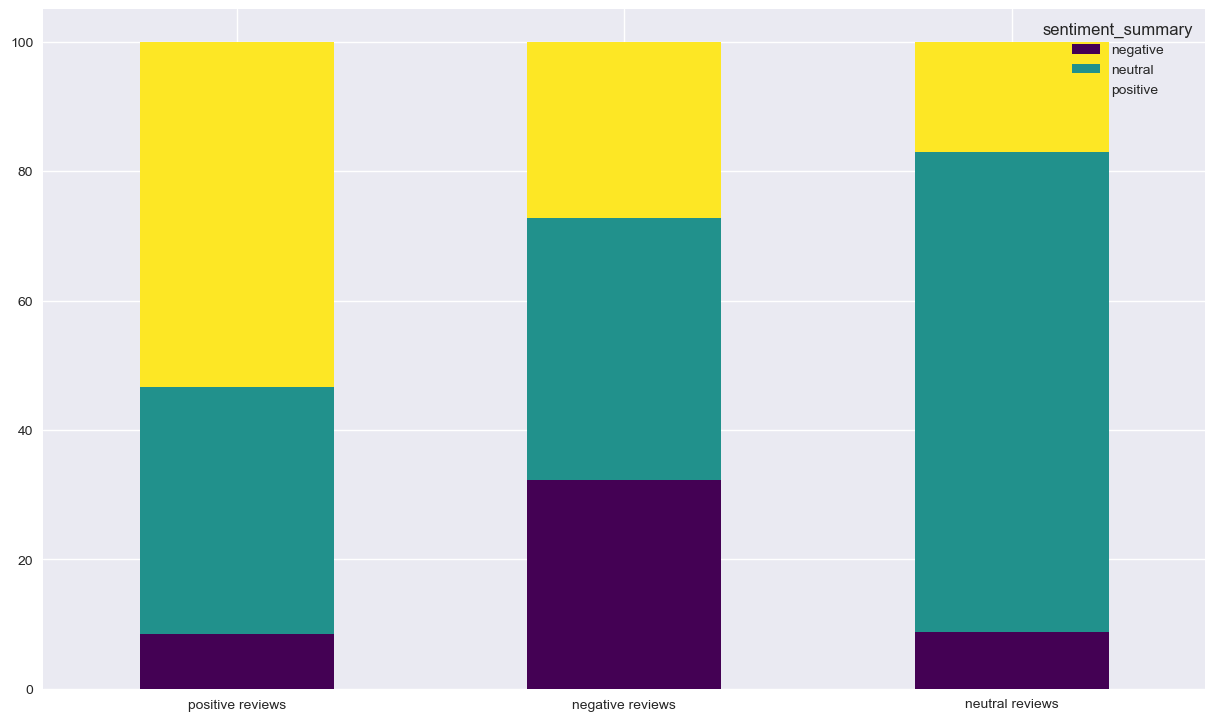

In [41]:
# Data normalization
final['positive reviews'] = 100 * final['positive reviews'] / final['positive reviews'].sum()
final['negative reviews'] = 100 * final['negative reviews'] / final['negative reviews'].sum()
final['neutral reviews'] = 100 * final['neutral reviews'] / final['neutral reviews'].sum()
final.T.plot(kind='bar', stacked=True, rot=0, figsize=(15,9), colormap='viridis')

### At this stage, we're going to focus on the  negative reviews, and try to understand why 40% of them has a positive prediction based on the summary. We're going to visualize the most frequent words of their summaries.

In [42]:
neg_pos = df[df.sentiment_review == 'negative']
neg_pos = neg_pos[neg_pos.sentiment_summary == 'positive']

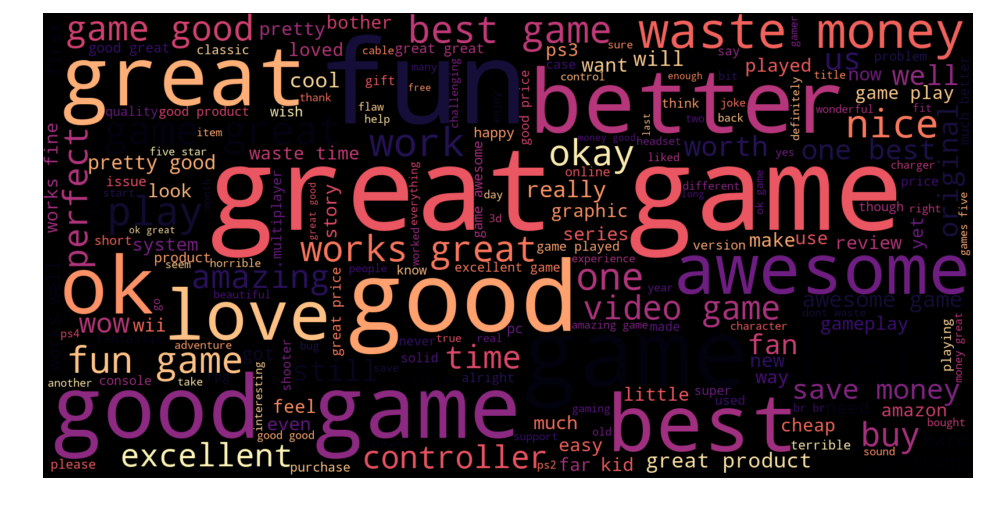

In [43]:
# These are the dominant words in the summaries that were classified as positive, but with negative review
summaries = []
for t in neg_pos.summary:
    summaries.append(t.lower())

summaries = pd.Series(summaries).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,background_color='black',colormap='magma',max_words=200).generate(summaries)

# Plot
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

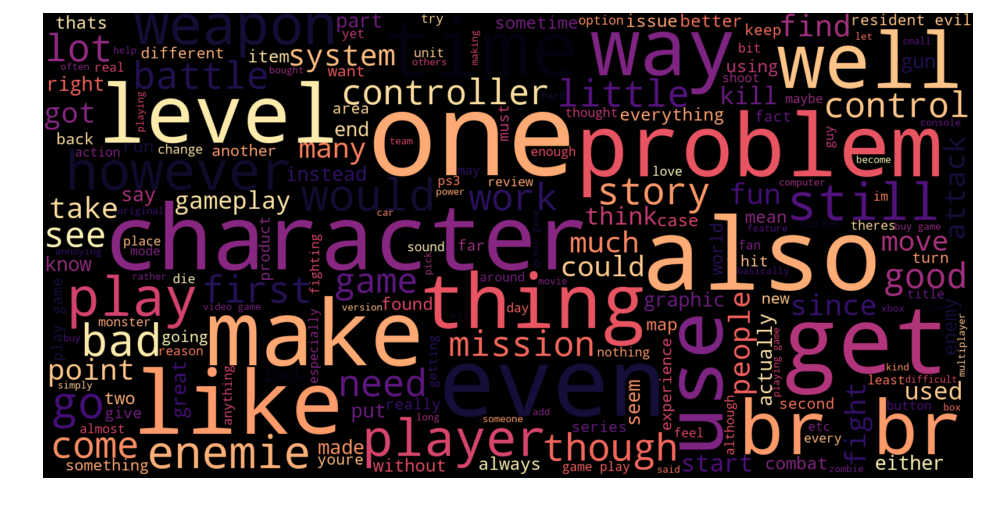

In [44]:
# These are the dominant words in the reviews that were classified as negative, but with positive summary
reviews = []
for t in neg_pos.reviewText:
    reviews.append(t.lower())

reviews = pd.Series(reviews).str.cat(sep=' ')
wordcloud = WordCloud(width=1600,stopwords = stop_w,  height=800,max_font_size=200,background_color='black',colormap='magma',max_words=200).generate(reviews)

# Plot
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Let's see the ratings associated to these reviews

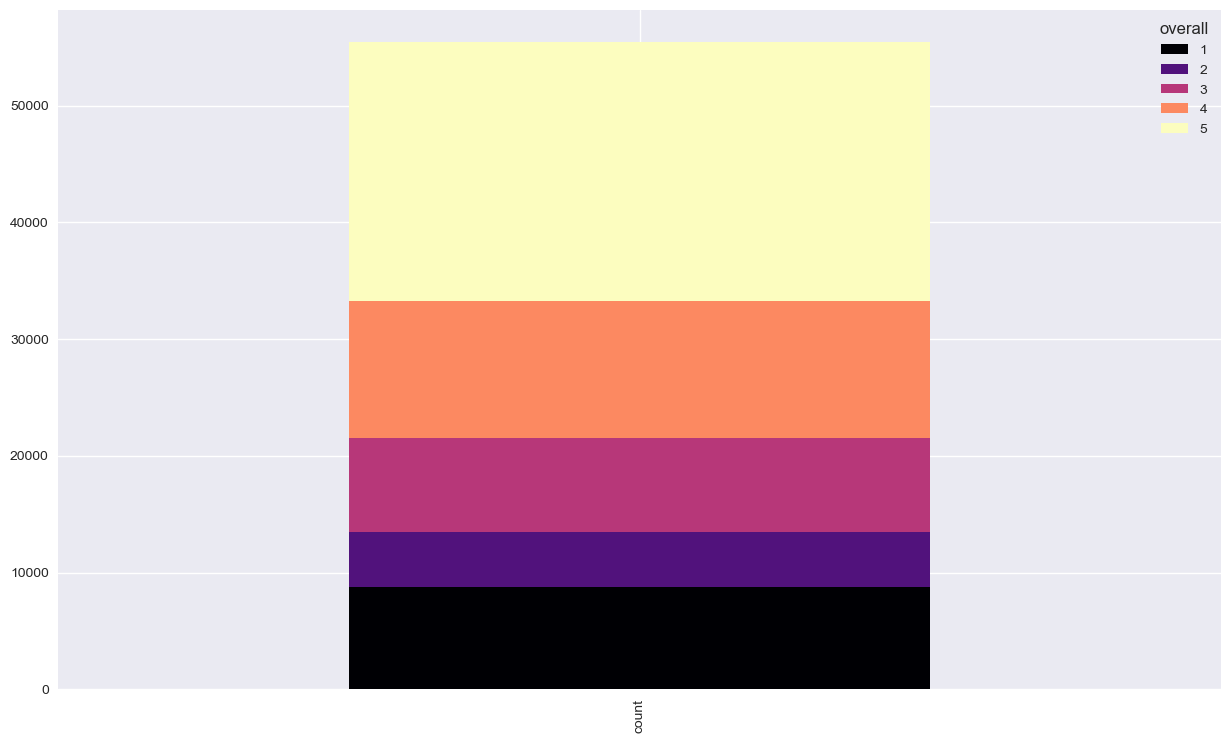

In [45]:
grouped = neg_pos.groupby('overall').agg({'count': sum})
grouped.T.plot(kind='bar', stacked=True, figsize=(15,9), colormap='magma')

In [46]:
# Misleading information
neg_5 = neg_pos[neg_pos.overall == 5][['reviewText', 'summary']]
neg_5['reviewText'].iloc[0]

# Let's see now the examples with ratings "1", which can say that the positive summary text was misleading
neg_1 = neg_pos[neg_pos.overall == 1][['reviewText', 'summary']]

# An example of a summary with a 1/5 rating
neg_1['summary'].iloc[4]

"Love the program, (use to own)but seller didn't send everything in order to load."

### Conclusion : The summary is way more meaningful in term of sentiment analysis, because it's short and then there are less chances to make mistakes in predictions, and also because the reviews with positive summary and negative review have a good rating ( usually 5 or 4 ), that's why we're going to focus more on it in building a classifier to confirm our conclusionv

We're going to consider that a review with a rating of 5 or 4 means a positive sentiment, 3 as neutral and 2 and 1 as positive. 

In [47]:
def to_sentiment(overall):
    if overall >= 4:
        sent = 1
    else:
        sent = 0
    return sent


classif = df[['summary','overall']]
classif['overall'] = classif['overall'].map(to_sentiment)

In [48]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.convolutional import Convolution1D
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers import LSTM
from keras.layers.recurrent import GRU

In [49]:
# We split our data into train and test: 70% for training and 30% for testing
msk = np.random.rand(len(df)) <= 0.7

train_set = classif[msk]
test_set = classif[~msk]
test_set
labels = train_set['overall'].values

In [50]:
# At this stage, we tain keras tokenizer
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(train_set['summary'].values)
dict_token = tokenizer.word_index # To see the dicstionary of words kept

# We store the number of features of the neural net since we havent' fixed it in tokenization
nb_features = len(dict_token)

# Converting tweets to sequences and then padding them
train_sequences = tokenizer.texts_to_sequences(train_set['summary'].values)
train_sequences_pad = sequence.pad_sequences(train_sequences, maxlen=30)
test_sequences = tokenizer.texts_to_sequences(test_set['summary'].values)
test_sequences_pad = sequence.pad_sequences(test_sequences, maxlen=30)

# Labels
labels = train_set['overall'].values

# building the model
embed_dim = 50
lstm_out = 100
model = Sequential()
model.add(Embedding(nb_features + 1, embed_dim, input_length=train_sequences_pad.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Fitting the model to training data
model.fit(train_sequences_pad, labels, validation_split=0.1, epochs=1, batch_size=128, verbose=1)

train_lstm = model.predict_proba(train_sequences_pad, batch_size=128)
test_lstm = model.predict_proba(test_sequences_pad, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 50)            3317600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,378,101
Trainable params: 3,378,101
Non-trainable params: 0
_________________________________________________________________
None
Train on 1122121 samples, validate on 124681 samples
Epoch 1/1
1122121/1122121 [==============================] - 377s 336us/step - loss: 0.2631 - acc: 0.8896 - val_loss: 0.3479 - val_acc: 0.8480


In [51]:
import _pickle as cPickle

# Save data to disk
cPickle.dump(train_lstm, open('train_lstm.dat', 'wb'))
cPickle.dump(test_lstm, open('test_lstm.dat', 'wb'))

In [52]:
# Reload data
train_lstm = cPickle.load(open("train_lstm.dat", "rb"))
test_lstm = cPickle.load(open("test_lstm.dat", "rb"))

labels.shape

(1246802,)

In [53]:
train_lstm.shape

(1246802, 1)

In [54]:
from sklearn.svm import LinearSVC

# Classification using linear SVC
clf = LinearSVC(random_state=0)
clf.fit(train_lstm, labels)
y_pred = clf.predict(test_lstm)

y_pred

[1 0 1 ... 1 1 1]


In [55]:
test_set['overall'].values.shape

(533352,)

In [56]:
def plot_confusion_matrix(cm):
    """
    Display the confusion matrix 
        :param cm: array
        :return: plot of the confusion matrix
    """
    plt.clf()
    plt.rcParams['figure.figsize'] = [21, 8]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Positive', 'Negative']
    plt.title('Confusion Matrix', fontsize=18)
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(s[i][j]) + " = " + str(cm[i][j]))
    plt.show()

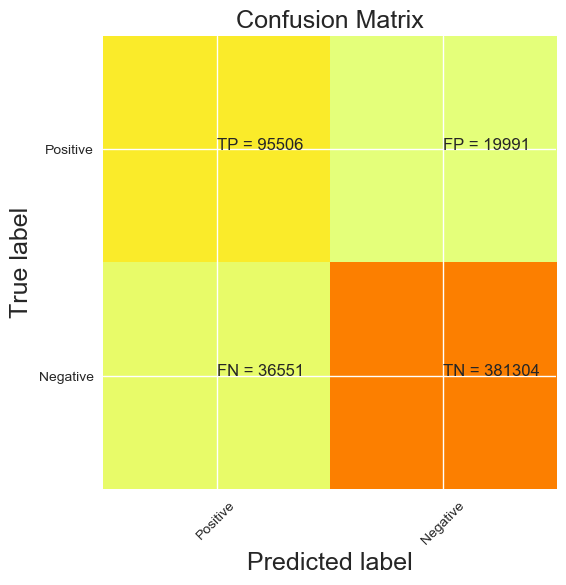

In [57]:
plot_confusion_matrix(sklearn.metrics.confusion_matrix(y_pred, test_set['overall'].values))

## Closure

This analysis was quite long and tiring, with many moments of hesitation and ideas' dropping. But, we finally focused on deep textual analysis and differences between the summary and the main review. We know now for sure that the reviews (and every text written by customers on people on social media) is not 100% reliable. In fact, even if everything was fine and coherent, NLP is very subjective and everything depends on small details: (choice of words, text's lenght, capitalization..)

After training our own model, we achieved good predictions and overall scores, but it is always hard to deal with what people write. Sometimes they are happy with the products but still complain about a detail, or they use a neutral language which makes it even harder to detect the sentiment. Some customers are funny or sarcastic, which is sometimes difficult for humans to understand, let alone an algorithm! (the famous summary "TOO GOOD TO BE TRUE"). We worked on different categories to try and see different behavior, which is kind of true when we focus on the lexical background of users but the overall insights are present everywhere! Such datasets and very rich and can serve for many other topics, but it is also difficult to work with without making assumptions, or at least without checking the veracity of each claim we made.